In [2]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']

In [3]:
from pymongo import MongoClient
from bson.objectid import ObjectId

import time,datetime
import os

import pandas as pd
import pandas_datareader.data as web
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import style

import pickle

from keras.models import Model, Sequential
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
import keras
from keras.callbacks import TensorBoard

from sklearn import preprocessing

from copy import deepcopy
from IPython.display import clear_output

In [4]:
style.use('ggplot')

In [5]:
# split a multivariate sequence into samples
def split_sequences_hour(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
       # find the end of this pattern
        end_ix = i + n_steps
#         print(end_ix)
        #check if we are beyond the dataset
        if end_ix > len(sequences)-1:
            break
        # gather input and output parts of the pattern
        seq_x = sequences[i:end_ix]#.reshape(len(sequences[i:end_ix]),1) 
#         print(seq_x)
#         break
#         seq_x = np.append(seq_x, sequences[1][i:end_ix].reshape(len(sequences[1][i:end_ix]),1), axis=1)
#         seq_x = np.append(seq_x, sequences[2][i:end_ix].reshape(len(sequences[2][i:end_ix]),1), axis=1)
        seq_y = sequences[end_ix][-1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [6]:
# coefficient of determination (R^2) for regression
def r_square(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return (1 - SS_res/(SS_tot + K.epsilon()))

def r_square_loss(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return 1 - ( 1 - SS_res/(SS_tot + K.epsilon()))

def r2_keras(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

tbCallBack = TensorBoard(log_dir='./logs',  # log 目录
             histogram_freq=0,  # 按照何等频率（epoch）来计算直方图，0为不计算
#                  batch_size=32,     # 用多大量的数据计算直方图
             write_graph=True,  # 是否存储网络结构图
             write_grads=True, # 是否可视化梯度直方图
             write_images=True,# 是否可视化参数
             embeddings_freq=0, 
             embeddings_layer_names=None, 
             embeddings_metadata=None)

In [7]:
# def start_hourly_predict(training_steps):
conn = MongoClient('120.126.136.17')
db = conn.Tracker
#     collection = [db.User_Info]# db.db2, db.dn2, db.james, db.leo
#     userInfo = []
#     for col in collection:
#         cursor = col.find({})
#         df_user = pd.DataFrame(list(cursor))

#     for username in df_user['']:
#         if username == 'pitest' or username == 'jack' or username == 'manager':
#             continue
collection = [db['james']]

# collection = [db.james]# db.db2, db.dn2, db.james, db.leo
clean_data = []
for col in collection:
    cursor = col.find({})
    df = pd.DataFrame(list(cursor))
df['step_value'].replace('', 0, inplace=True)
df.replace('', np.nan, inplace=True)
df.fillna(method='ffill', inplace=True)

df['hr_value'] = df['hr_value'].astype(float)
df['o2_value'] = df['o2_value'].astype(float)
df['latitude'] = df['latitude'].astype(float)
df['longitude'] = df['longitude'].astype(float)
df['step_value'] = df['step_value'].astype(float)

# map out the weekday
df['weekday'] = df['timestamp'].apply(lambda x: datetime.datetime.fromtimestamp(x).strftime('%w'))
df['week'] = df['timestamp'].apply(lambda x: datetime.datetime.fromtimestamp(x).isocalendar()[1]
          - (datetime.datetime.fromtimestamp(x).isoweekday() < 7)) # do this so that week may start on monday

dfstephour = pd.DataFrame({})
dfstephour = df[['week', 'weekday']].set_index(['week', 'weekday'])
dfstephour = dfstephour[~dfstephour.index.duplicated(keep='first')]
earlestweek = df['week'].values[0]
latestweek = df['week'].values[-1]
addindex = pd.DataFrame({})
for i in range(earlestweek, latestweek):
    for j in range(7):
        if not (i,str(j)) in dfstephour.index:
            add = pd.DataFrame({'week':[i],'weekday':[str(j)]})
            addindex = addindex.append(add)
dfstephour.reset_index(inplace=True)
dfstephour = dfstephour.append(addindex)
dfstephour = dfstephour.set_index(['week', 'weekday'])
dfstephour = dfstephour.sort_index()
for i in range(24):
    dfstephour[i] = 0

# here I map between integer and the sting it's mean
timeslidemap = {0:'msteps', 1:'asteps', 2:'esteps'}
basestamp = df['timestamp'][0]
endstamp = df['timestamp'][-1:].values[0]
# for num, row in df[:30000].iterrows():
while True:
    try:
        hour = datetime.datetime.fromtimestamp(basestamp).hour
        dfbetween = df.loc[df['timestamp'].between(
            datetime.datetime.fromtimestamp(basestamp).replace(hour=hour,minute=0,second=0).timestamp(),
            datetime.datetime.fromtimestamp(basestamp).replace(hour=hour,minute=59,second=59).timestamp()
                    , inclusive=True)]
        steps = dfbetween['step_value'].sum()
    #     print(int(datetime.datetime.fromtimestamp(basestamp).strftime('%m')),
    #             int(datetime.datetime.fromtimestamp(basestamp).strftime('%d')),
    #                 timeslidemap[estimedevide])

        dfstephour.loc[[(datetime.datetime.fromtimestamp(basestamp).isocalendar()[1] - 
                                    (datetime.datetime.fromtimestamp(basestamp).isoweekday() < 7),
                            datetime.datetime.fromtimestamp(basestamp).strftime('%w'))], 
                                           [hour]] += steps

        basestamp = (datetime.datetime.fromtimestamp(basestamp) + datetime.timedelta(hours=1)).timestamp()
        if basestamp > endstamp:
            break
    except Exception as e:
#         print(str(e))
        basestamp = (datetime.datetime.fromtimestamp(basestamp) + datetime.timedelta(hours=1)).timestamp()
#     else:
#         print(datetime.datetime.fromtimestamp(basestamp) ,datetime.datetime.fromtimestamp(endstamp))
steps = dfstephour.values
train_X = []
for weekday,i in enumerate(steps):
    for hour,j in enumerate(i):
        add = np.array([j])#[weekday, hour, j]
        train_X.append(add)
# the ending of training data is the  hour of now 
train_X = train_X[:-(24-datetime.datetime.now().time().hour + 1)]
train_X = np.array(train_X)

conn.close()

In [8]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import SimpleRNN

In [9]:
n_steps = 7
X, y = split_sequences_hour(train_X, n_steps)

n_features = 1
model = Sequential()
model.add(keras.layers.LSTM(55,activation='relu', return_sequences=True,input_shape=(n_steps, n_features),dropout=0.1))
model.add(keras.layers.LSTM(20, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='Adadelta', loss='mse',metrics=[r2_keras])# 
history = model.fit(X, y, epochs=500, verbose=0, batch_size=128, validation_split=0.2, callbacks=[tbCallBack])

del model

<IPython.core.display.Javascript object>


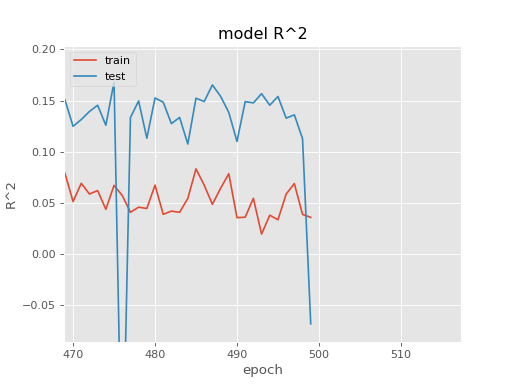

In [10]:
%matplotlib notebook
plt.plot(history.history['val_r2_keras'])
plt.plot(history.history['r2_keras'])
plt.title('model R^2')
plt.ylabel('R^2')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [109]:
n_steps = 7
X, y = split_sequences_hour(train_X, n_steps)

n_features = 1
model = Sequential()
model.add(keras.layers.LSTM(60,activation='relu', return_sequences=True,input_shape=(n_steps, n_features),dropout=0.1))
model.add(keras.layers.LSTM(20, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='Adadelta', loss='mse',metrics=[r2_keras])# 
history = model.fit(X, y, epochs=500, verbose=0, batch_size=128, validation_split=0.2, callbacks=[tbCallBack])

del model

<IPython.core.display.Javascript object>


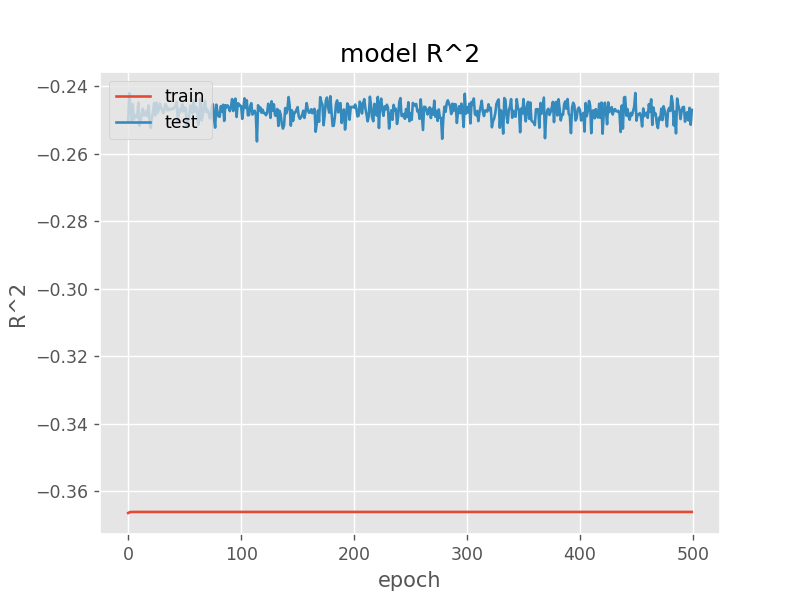

In [110]:
%matplotlib notebook
plt.plot(history.history['val_r2_keras'])
plt.plot(history.history['r2_keras'])
plt.title('model R^2')
plt.ylabel('R^2')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

<IPython.core.display.Javascript object>


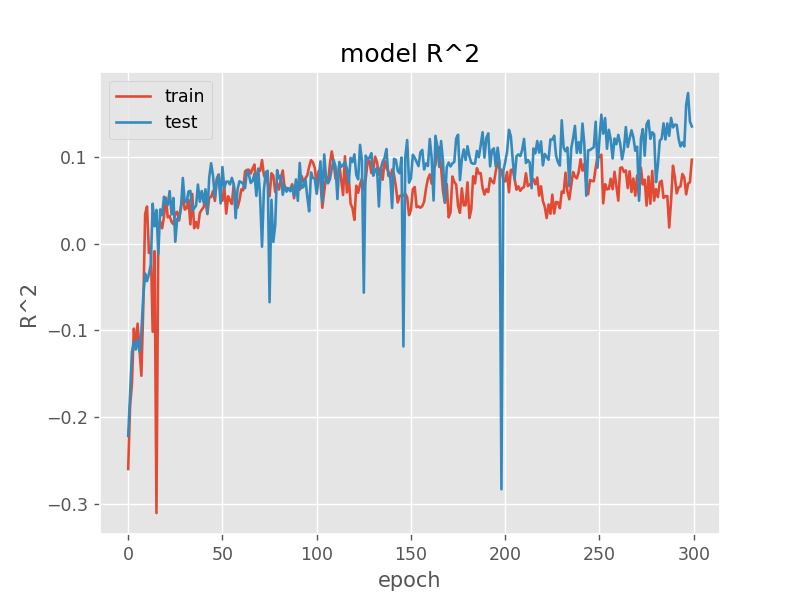

In [75]:
# optimizer : Adadelta

%matplotlib notebook
plt.plot(history.history['val_r2_keras'])
plt.plot(history.history['r2_keras'])
plt.title('model R^2')
plt.ylabel('R^2')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()